In [2]:
# Условие этой лабы очень простое: построить непараметрическую регрессию. 
# Вы можете использовать любые из существующих методов построения непараметрической регрессии, 
# однако Вы должны уметь доступно и с формулками объяснять, что у Вас происходит и как оно считается. 
# Требуется реализовать минимум 2 метода. Также требуется посчитать MSE, а также рисовать всякие графики.

In [18]:
%matplotlib inline
%load_ext autoreload
%autoreload 5
%autosave 15    
import numpy as np
import pandas as pd
import math
import random
import pylab as pl
import matplotlib.pyplot as plt
from sklearn.cross_validation import KFold
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.metrics import accuracy_score, f1_score
from scipy.spatial.distance import euclidean, cityblock, cosine, correlation
from IPython.display import display, HTML
from sklearn.metrics import mean_squared_error
plt.rcParams["figure.figsize"]=[15,10]

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Autosaving every 15 seconds


In [19]:
data = pd.read_table("D:/Users/Daria/Code2/MachineLearning/hw5_non_parametr_regression/non-parametric.csv", sep=";", header=0, names=['id', 'x', 'y'])
points = data[['x', 'y']].as_matrix()

In [3]:
# kernels
square_kernel = lambda u: 15.0 / 16 * (1 - u ** 2) ** 2 * (abs(u) <= 1)
epan_kernel = lambda u: 0.75 * (1 - u ** 2) * (abs(u) <= 1)
gauss_kernel = lambda u: (2 * math.pi) ** (-1.0 / 2)* math.exp(-u ** 2 / 2.0)
triangle_kernel = lambda u: (1 - abs(u)) * (abs(u) <= 1)
rectangle_kernel = lambda u: 1.0 / 2 * (abs(u) <= 1)
LOWESS_kernel = lambda u: (1 - u ** 2) ** 2 * (abs(u) <= 1)
kernels = [square_kernel, epan_kernel, gauss_kernel, triangle_kernel, rectangle_kernel]
kernelStr = dict()
kernelStr[square_kernel] = "square kernel"
kernelStr[epan_kernel] = "epan kernel"
kernelStr[gauss_kernel] = "gauss kernel"
kernelStr[triangle_kernel] = "triangle kernel"
kernelStr[rectangle_kernel] = "rectangle kernel"
metrics = [cityblock, euclidean, cityblock, cosine, correlation]

In [12]:
curKernel = gauss_kernel
dist = euclidean
delta = [1] * len(points)
maxi = int(max([xi for [xi, yi] in points]))
optH = 3
def getOptimalH():    
    h = optH
    mini = sum([(getY(points[i][0], h, i) - points[i][1]) ** 2 for i in range(len(points))])    
    hh = 1.1
    while (hh < 10):
        curM = sum([(getY(points[i][0], hh, i) - points[i][1]) ** 2 for i in range(len(points))])
        print(hh, " ", curM)
        if (curM < mini):
            mini = curM
            h = hh 
        hh += 0.5
    return h
    
def getY(x, curH, exceptPoint=-1):
    a = 0.0
    b = 0.0
    for i in range(len(points)):        
        if (i == exceptPoint):
            continue
        [xi, yi] = points[i]
        wi = curKernel(dist(x, xi) / curH)
        a += yi * wi * delta[i]
        b += wi * delta[i]
    if (b == 0):
        return 0
    return a / b

def LOWESS():
    for k in range(3):
        curY = []        
        for i in range(len(points)):            
            res = getY(points[i][0], optH, i)
            curY.append(res)
        s = np.median([abs(curY[i] - points[i][1]) for i in range(len(points))])
        for i in range(len(points)):
            epsi = abs(curY[i] - points[i][1])
            delta[i] = LOWESS_kernel(epsi / (6.0 * s))  

In [13]:
# k Nearest Neighbors algorithm
def kNN(x, k, exceptPoint=-1):
    k = min(k, len(points))        
    distances = [[tpoint[0], tpoint[1], dist([x, 0], [tpoint[0], 0])] for tpoint in points]
    distances.sort(key=lambda p:p[2])
    #klargest
    a = 0.0
    b = 0.0
    curH = abs(x - distances[k - 1][0])
    for i in range(k):        
        [xi, yi] = distances[i][:2]
        if xi == x and yi == exceptPoint and exceptPoint > 0:
            i -= 1
            continue
        wi = curKernel(dist(x, xi) / (dist(x, curH) + 1))
        a += yi * wi
        b += wi
    if (b == 0):
        return 0
    return a / b

In [14]:
# spline
# x(t) = ((a3t + a2)t + a1)t + a0, для 0 <= t <= 1
# y(t) = ((b3t + b2)t + b1)t + b0, для 0 <= t <= 1
m = 10
def spline():
    res = []
    for i in range(1, len(points) - 2):        
        xA, xB, xC, xD = points[i - 1][0], points[i][0], points[i + 1][0], points[i + 2][0]
        yA, yB, yC, yD = points[i - 1][1], points[i][1], points[i + 1][1], points[i + 2][1]
        
        a3 = (-xA + 3 * (xB - xC) + xD) / 6.0
        a2 = (xA - 2 * xB + xC) / 2.0
        a1 = (xC - xA) / 2.0
        a0 = (xA + 4 * xB + xC) / 6.0
        b3 = (-yA + 3 * (yB - yC) + yD) / 6.0
        b2 = (yA - 2 * yB + yC) / 2.0
        b1 = (yC - yA) / 2.0
        b0 = (yA + 4 * yB + yC) / 6.0
#         print(a0, a1, a2, a3, b0, b1, b2, b3)
        for j in range(m):
            t = (j + 1) / m
            curX = ((a3 * t + a2) * t + a1) * t + a0
            curY = ((b3 * t + b2) * t + b1) * t + b0
#             print(curX, curY)
            res.append([curX, curY])
    return res

def getYspline(x):        
    xx = points[0][0]
    yy = points[0][1]
    for i in range(1, len(points) - 2):        
        xA, xB, xC, xD = points[i - 1][0], points[i][0], points[i + 1][0], points[i + 2][0]
        yA, yB, yC, yD = points[i - 1][1], points[i][1], points[i + 1][1], points[i + 2][1]
        if not (x >= xA and x <= xD):
            continue
        a3 = (-xA + 3 * (xB - xC) + xD) / 6.0
        a2 = (xA - 2 * xB + xC) / 2.0
        a1 = (xC - xA) / 2.0
        a0 = (xA + 4 * xB + xC) / 6.0
        b3 = (-yA + 3 * (yB - yC) + yD) / 6.0
        b2 = (yA - 2 * yB + yC) / 2.0
        b1 = (yC - yA) / 2.0
        b0 = (yA + 4 * yB + yC) / 6.0
#         print(a0, a1, a2, a3, b0, b1, b2, b3)        
        for j in range(m):
            t = (j + 1) / m
            curX = ((a3 * t + a2) * t + a1) * t + a0
            curY = ((b3 * t + b2) * t + b1) * t + b0
            if (abs(curX - x) < abs(xx - x)):
                xx = curX
                yy = curY
#             print(curX, curY)   
#     print(x, xx)
    return yy
    

smoothing, kernel = square kernel ; h = 9 ; mean squared error = 1116.98807634
smoothing, kernel = epan kernel ; h = 9 ; mean squared error = 1250.41022645
smoothing, kernel = gauss kernel ; h = 9 ; mean squared error = 1832.57273854
smoothing, kernel = triangle kernel ; h = 9 ; mean squared error = 1159.7877955
smoothing, kernel = rectangle kernel ; h = 9 ; mean squared error = 1537.77530166
kNN, k =  8 ; mean squared error =  821.893316852
kNN, k =  9 ; mean squared error =  842.762674563
kNN, k =  10 ; mean squared error =  851.973287068
kNN, k =  11 ; mean squared error =  847.33285671
kNN, k =  12 ; mean squared error =  842.659011648
kNN, k =  13 ; mean squared error =  844.9763572
kNN, k =  14 ; mean squared error =  849.089085085
kNN, k =  15 ; mean squared error =  838.365474707
kNN, k =  16 ; mean squared error =  851.007437436
kNN, k =  17 ; mean squared error =  862.371304294
spline; mean squared error =  307.441434997


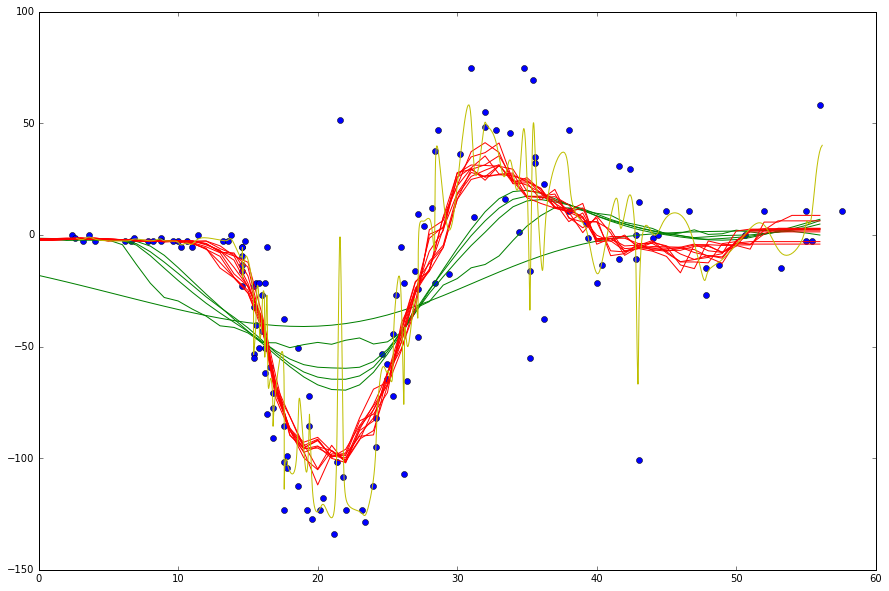

In [25]:
transformations = [lambda x: x]#, lambda x: x ** 2, lambda x: x ** 0.5]
metrics = [cityblock, euclidean, cityblock, cosine, correlation]
showPoints(points, 'b', 'o')
optH = 3
for kernel in kernels:
    curKernel = kernel
#     optH = getOptimalH()
    LOWESS() 
#     print(delta)    
#     for h in range(3, 10):
    curP = []        
    for x in range(0, maxi):
        curP.append([x, getY(x, optH)])
    print("smoothing, kernel =", kernelStr[curKernel], "; h =", optH, "; mean squared error =", mean_squared_error([yi for [xi, yi] in points], [getY(xi, optH) for [xi, yi] in points]))
    showPoints(curP, 'g', '-')    
for k in range(8, 18):
    kNNres = []
    for x in range(0, maxi):
        kNNres.append([x, kNN(x, k)])
    showPoints(kNNres, 'r', '-')
    print("kNN, k = ", k, "; mean squared error = ", mean_squared_error([yi for [xi, yi] in points], [kNN(xi, k, yi) for [xi, yi] in points]))
splines = spline()
print("spline; mean squared error = ", mean_squared_error([yi for [xi, yi] in points], [getYspline(xi) for [xi, yi] in points]))
showPoints(splines, 'y', '-')
show()

In [ ]:
def showPoints(ticks, color, style):    
    x_ticks = [xi for [xi, yi] in ticks]
    y_ticks = [yi for [xi, yi] in ticks]
    plt.plot(x_ticks, y_ticks, color + style)
def show():
#     plt.figure(figsize=(3,4))
    plt.show()

In [10]:
# k-fold cross-validation
def training(data, k, metrics, kNN_value):
    kf = KFold(len(data), n_folds=k, shuffle=True)
    averageAccuracy = 0
    for train_index, test_index in kf:
        train = data.loc[train_index].as_matrix()
        test = data.loc[test_index].as_matrix()
        result = kNN(kNN_value, metrics, train, test)
        #f1 measure =  2 * (precision * recall) / (precision + recall)
        f1 = f1_score([row[2] for row in test], [row[3] for row in result]) 
        averageAccuracy += f1
    averageAccuracy /= k
    return averageAccuracy